# **Step 0: Importing Data and Libraries**

In [82]:
!pip install sentence-transformers

In [83]:
# Importing all the necessary variables

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import warnings
import sys
warnings.filterwarnings("ignore")

In [84]:
application_samples_df=pd.read_csv('application_samples.csv')
credit_features_df=pd.read_csv('credit_features.csv')

In [85]:
final_df=pd.merge(application_samples_df, credit_features_df, on='UID')
final_df.shape

(8847, 20)

# **Step 1 : Exploratory Data Analysis**

# **1.1) Dealing with the Date Column**

In [5]:
# Convert ApplicationDate to datetime
final_df['ApplicationDate'] = pd.to_datetime(final_df['ApplicationDate'], errors='coerce')

In [6]:
# Feature Engineering - Extract date components
final_df['Year'] = final_df['ApplicationDate'].dt.year
final_df['Month'] = final_df['ApplicationDate'].dt.month
final_df['DayOfWeek'] = final_df['ApplicationDate'].dt.dayofweek  # 0 = Monday, 6 = Sunday
final_df['Quarter'] = final_df['ApplicationDate'].dt.quarter
final_df['IsWeekend'] = (final_df['DayOfWeek'] >= 5).astype(int)  # 1 = Weekend, 0 = Weekday


In [7]:
final_df.columns

Index(['UID', 'ApplicationDate', 'Amount', 'Term', 'EmploymentType',
       'LoanPurpose', 'Success', 'ALL_AgeOfOldestAccount',
       'ALL_AgeOfYoungestAccount', 'ALL_Count', 'ALL_CountActive',
       'ALL_CountClosedLast12Months', 'ALL_CountDefaultAccounts',
       'ALL_CountOpenedLast12Months', 'ALL_CountSettled', 'ALL_MeanAccountAge',
       'ALL_SumCurrentOutstandingBal', 'ALL_SumCurrentOutstandingBalExcMtg',
       'ALL_TimeSinceMostRecentDefault',
       'ALL_WorstPaymentStatusActiveAccounts', 'Year', 'Month', 'DayOfWeek',
       'Quarter', 'IsWeekend'],
      dtype='object')

# **1.2) Univariate Analysis of Variables**


*   Univariate Analysis of Categorical Variables
*   Univariate Analysis of Numerical variables
*   Univariate anaysis of Target variable (For Class Imbalance check)






In [8]:
# Extracting the Categorical variables
categorical_columns = [final_df[i].name  for i in final_df.columns if final_df[i].dtype=='object']
categorical_columns

['EmploymentType', 'LoanPurpose']

In [9]:
# Frequency count of each Employment type
final_df['EmploymentType'].value_counts(normalize=True)

,proportion
EmploymentType,
Employed - full time,0.871934
Employed - part time,0.064429
Self employed,0.047248
Retired,0.016390


In [10]:
# Frequency count of applications across Quarters
final_df['Quarter'].value_counts(normalize=True).sort_index()


,proportion
Quarter,
1.0,0.249728
2.0,0.264690
3.0,0.243199
4.0,0.242383


In [11]:
# Frequency count of applications across day of the week
final_df['DayOfWeek'].value_counts(normalize=True).sort_index()

,proportion
DayOfWeek,
0.0,0.128945
1.0,0.132209
2.0,0.162133
3.0,0.152339
4.0,0.140370
5.0,0.124048
6.0,0.159956


In [12]:
# Target Variable - Success Distribution
final_df['Success'].value_counts(normalize=True)

,proportion
Success,
0,0.895784
1,0.104216


Insights -


*   87% of people applying for loan are full time employees

*   Applications are equally distributed across all the Quarters in the year with arount 30% in first quarter and around 23% in each of the other quarters
*   89% of the loans got rejected and only 10% got accepted which is a high class imbalance for the target variable - We need to resample to remove class imbalence




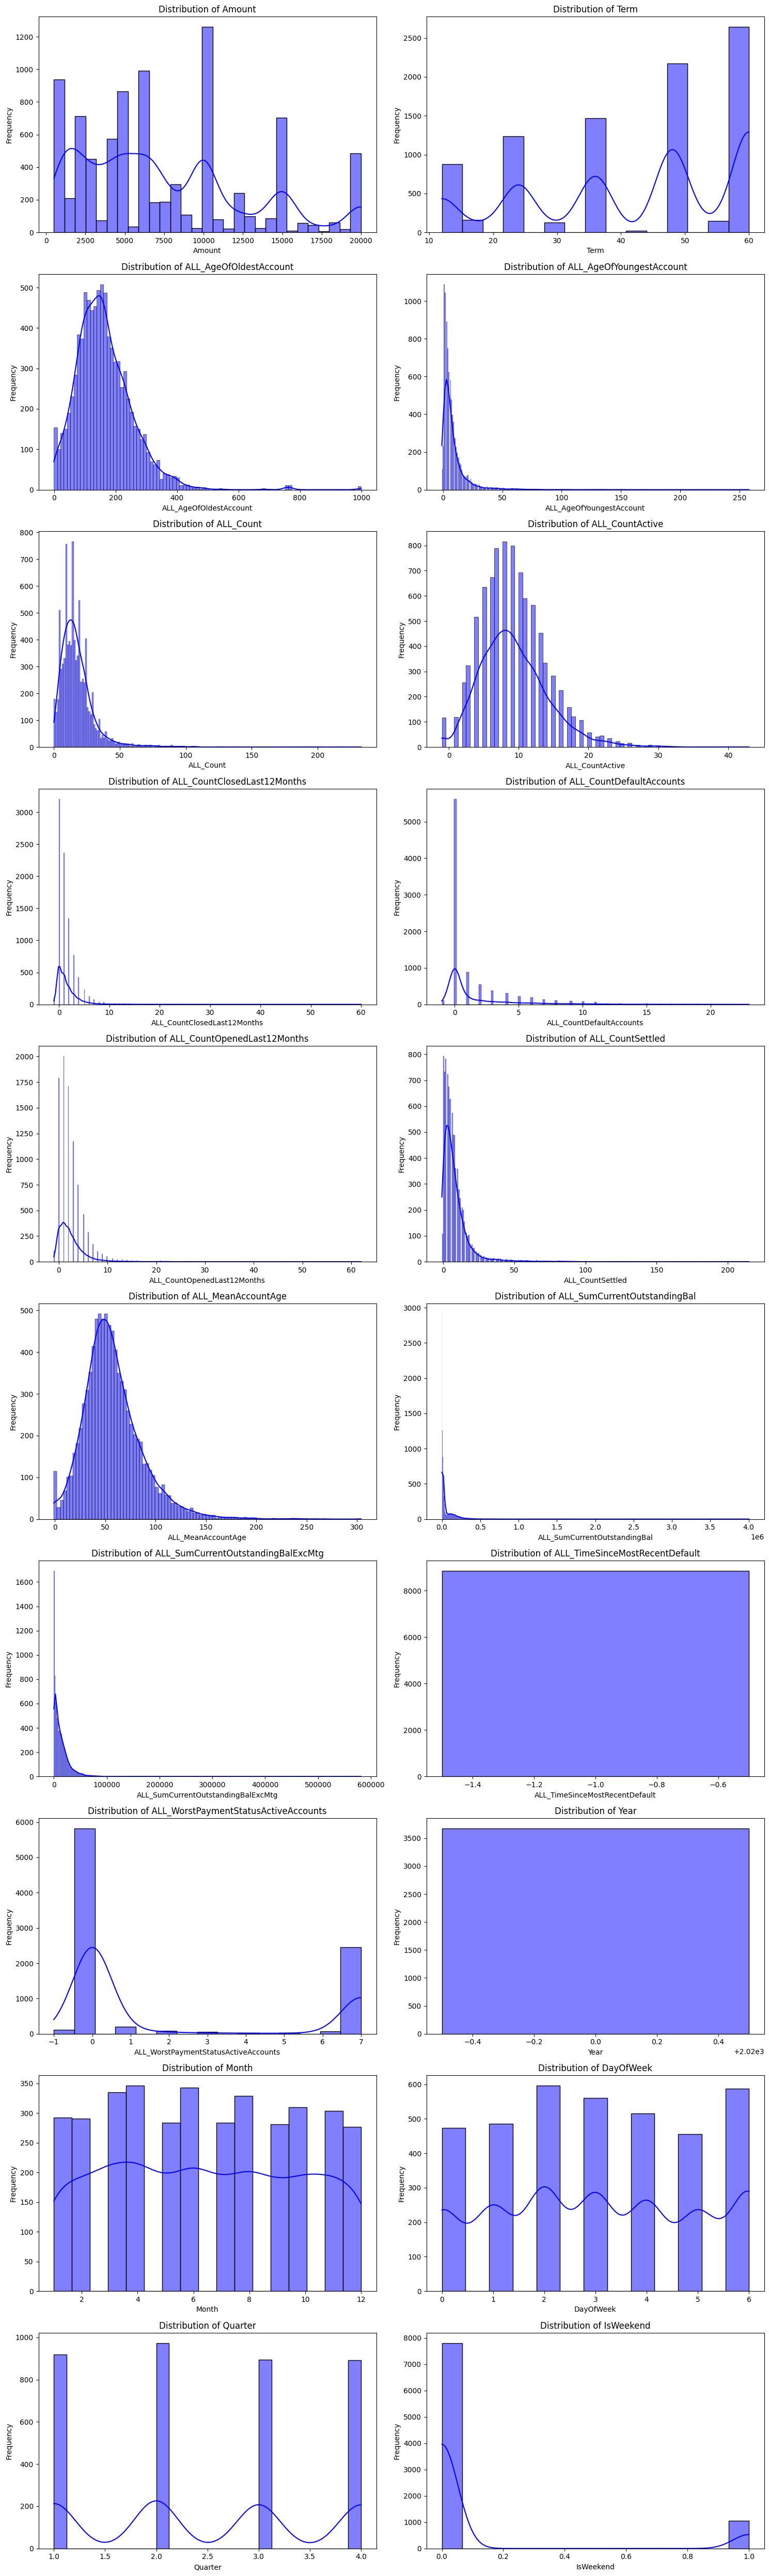

In [13]:
# Distribution and spread of Numerical variables (Histogram and Kernal Density Estimation)

import math
import seaborn as sns
import matplotlib.pyplot as plt

# Filter numerical columns
numerical_columns = final_df.select_dtypes(include=['number']).columns
numerical_columns = list(numerical_columns)
if 'UID' in numerical_columns: numerical_columns.remove('UID')  # Remove unwanted columns
if 'Success' in numerical_columns: numerical_columns.remove('Success')

# Number of subplots needed
num_cols = len(numerical_columns)
rows = math.ceil(num_cols / 2)  # Dynamic row calculation for 2 columns per row

# Create subplots
plt.figure(figsize=(15, 5 * rows))  # Adjust figure height based on rows
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(rows, 2, i)  # Dynamically create rows x 2 grid of subplots
    sns.histplot(data=final_df, x=col, kde=True, color='blue')  # Histogram with KDE
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



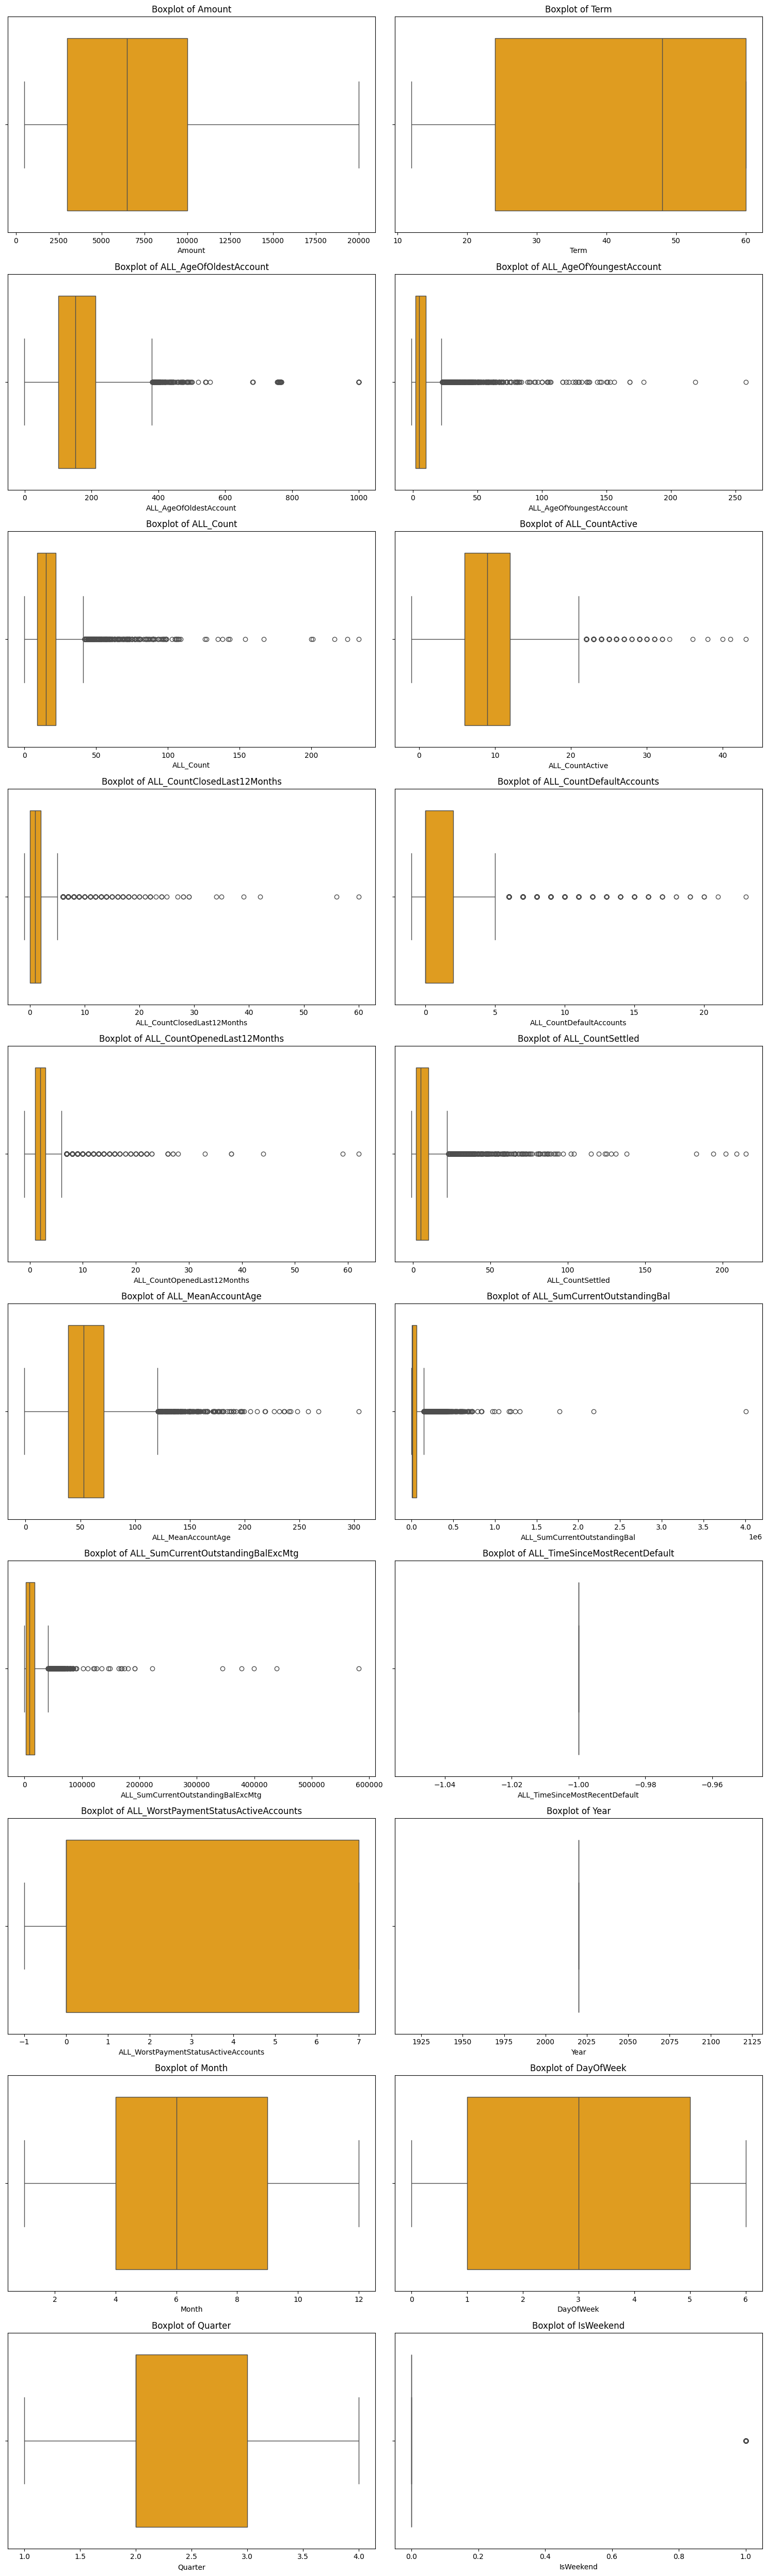

In [14]:
# Boxplots of the numerical variables to identify any outliers

# Number of subplots needed
num_cols = len(numerical_columns)
rows = math.ceil(num_cols / 2)  # Dynamic row calculation for 2 columns per row

# Create subplots for boxplots
plt.figure(figsize=(15, 5 * rows))  # Adjust figure height based on rows
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(rows, 2, i)  # Dynamically create rows x 2 grid of subplots
    sns.boxplot(data=final_df, x=col, color='orange')  # Boxplot
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


Insights (Amount Variable)-


- Multiple peaks suggest that the data is multimodal, meaning the data represents different groups or patterns.
- No visible outliers are indicated in box plot, as no points are beyond the whiskers
*   The density is not uniform in violin plot, with some sections being much more concentrated than others.




# **1.3) Bivariate Analysis**
- Employment type wrt to the Success
- Numerical variables wrt to Success

Text(0, 0.5, 'Count')

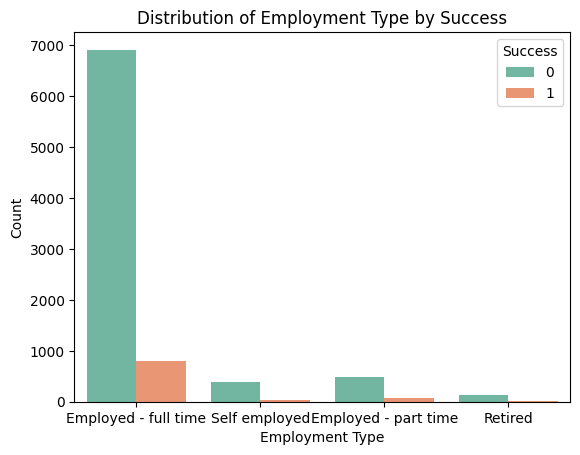

In [15]:
sns.countplot(data=final_df, x='EmploymentType', hue='Success', palette='Set2')  # Count plot with Success as hue
plt.title(f'Distribution of Employment Type by Success')
plt.xlabel('Employment Type')
plt.ylabel('Count')

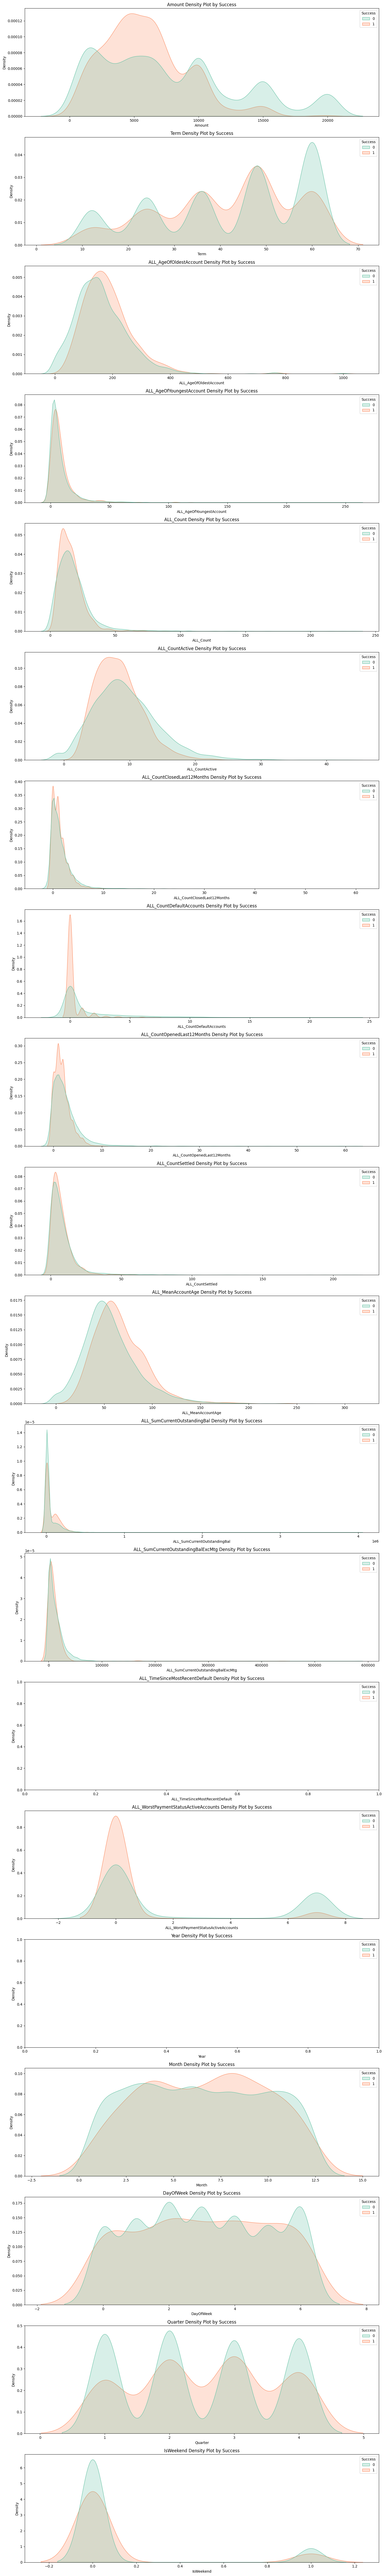

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Categorical vs. Success (Density plots are not typically used for categorical variables)
# So, we'll focus on numerical vs Success for density plots

# Numerical vs. Success (Density plots)
numerical_columns = final_df.select_dtypes(include=['number']).columns
numerical_columns = list(numerical_columns)
if 'UID' in numerical_columns: numerical_columns.remove('UID')  # Remove unwanted columns
if 'Success' in numerical_columns: numerical_columns.remove('Success')

# Create subplots for numerical variables vs Success using density plots (KDE)
plt.figure(figsize=(15, 5 * len(numerical_columns)))  # Adjust figure size based on the number of numerical columns
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, i)
    sns.kdeplot(data=final_df, x=col, hue='Success', fill=True, common_norm=False, palette='Set2')  # KDE plot
    plt.title(f'{col} Density Plot by Success')
    plt.xlabel(col)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()


In [17]:
corr = final_df[['Amount', 'Success']].corr()
print(corr)

         Amount  Success
Amount   1.0000  -0.1088
Success -0.1088   1.0000


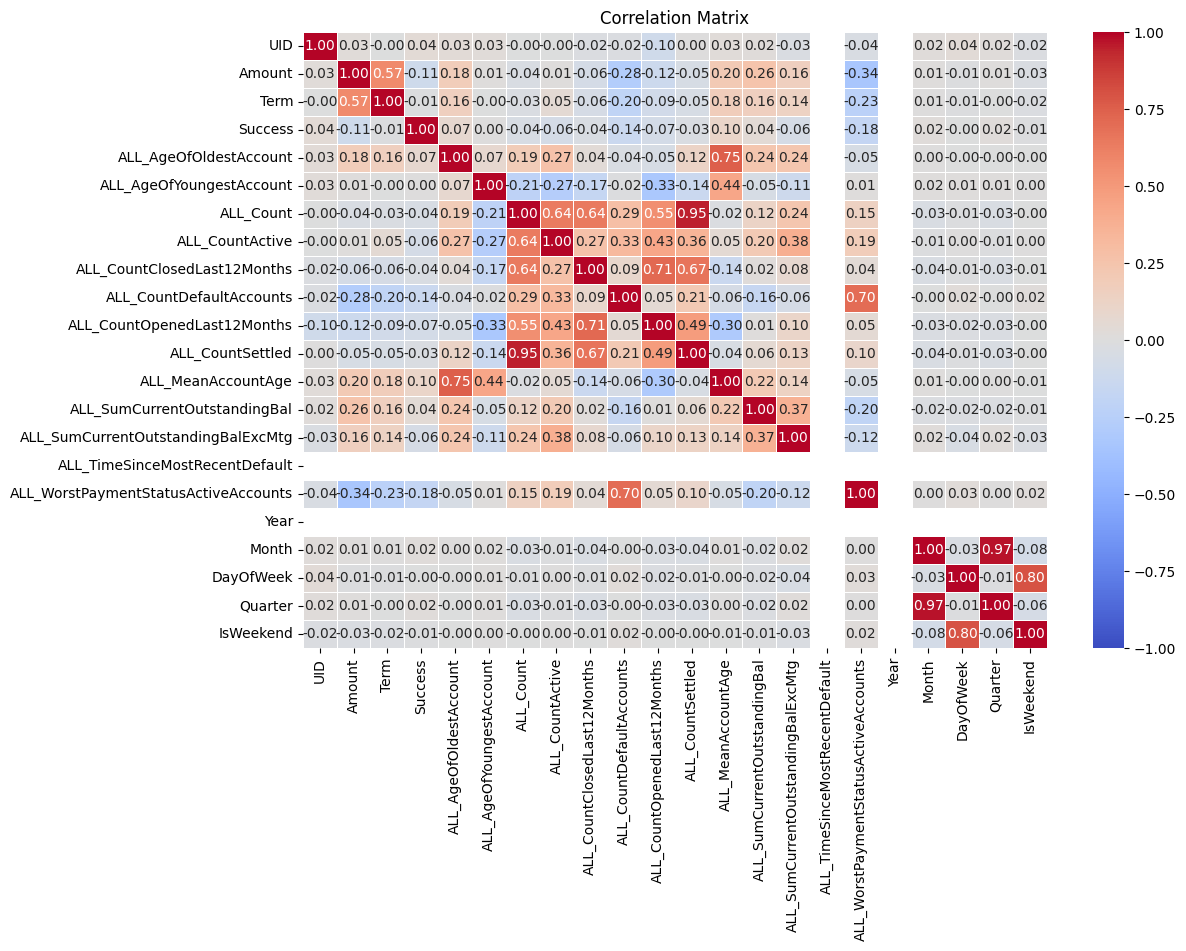

In [18]:
# Select only numeric columns
numerical_df = final_df.select_dtypes(include=['number'])


# Calculate the correlation matrix for the numerical columns
correlation_matrix = numerical_df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


In [19]:
# Assuming 'Success' is your target variable
correlation_with_target = correlation_matrix['Success'].sort_values(ascending=False)
print(correlation_with_target)


Success                                 1.000000
ALL_MeanAccountAge                      0.103557
ALL_AgeOfOldestAccount                  0.074819
ALL_SumCurrentOutstandingBal            0.043025
UID                                     0.042425
Quarter                                 0.020608
Month                                   0.018144
ALL_AgeOfYoungestAccount                0.001227
DayOfWeek                              -0.002266
Term                                   -0.010138
IsWeekend                              -0.011240
ALL_CountSettled                       -0.026158
ALL_CountClosedLast12Months            -0.037209
ALL_Count                              -0.044824
ALL_SumCurrentOutstandingBalExcMtg     -0.058709
ALL_CountActive                        -0.064471
ALL_CountOpenedLast12Months            -0.074136
Amount                                 -0.108800
ALL_CountDefaultAccounts               -0.139361
ALL_WorstPaymentStatusActiveAccounts   -0.179112
ALL_TimeSinceMostRec

# **1.4) Encoding Categorical Variables**
- Remove UID, Date, Loan Purpose, Months since most recent default
- Encode Employment Type
- Normalise/Standardise Data frame

In [20]:
final_df.columns

Index(['UID', 'ApplicationDate', 'Amount', 'Term', 'EmploymentType',
       'LoanPurpose', 'Success', 'ALL_AgeOfOldestAccount',
       'ALL_AgeOfYoungestAccount', 'ALL_Count', 'ALL_CountActive',
       'ALL_CountClosedLast12Months', 'ALL_CountDefaultAccounts',
       'ALL_CountOpenedLast12Months', 'ALL_CountSettled', 'ALL_MeanAccountAge',
       'ALL_SumCurrentOutstandingBal', 'ALL_SumCurrentOutstandingBalExcMtg',
       'ALL_TimeSinceMostRecentDefault',
       'ALL_WorstPaymentStatusActiveAccounts', 'Year', 'Month', 'DayOfWeek',
       'Quarter', 'IsWeekend'],
      dtype='object')

In [21]:
# Remove multiple columns (e.g., 'Column1', 'Column2', and 'Column3')
final_df.drop(columns=['UID', 'ApplicationDate', 'ALL_TimeSinceMostRecentDefault','Year'], inplace=True)
final_df.columns


Index(['Amount', 'Term', 'EmploymentType', 'LoanPurpose', 'Success',
       'ALL_AgeOfOldestAccount', 'ALL_AgeOfYoungestAccount', 'ALL_Count',
       'ALL_CountActive', 'ALL_CountClosedLast12Months',
       'ALL_CountDefaultAccounts', 'ALL_CountOpenedLast12Months',
       'ALL_CountSettled', 'ALL_MeanAccountAge',
       'ALL_SumCurrentOutstandingBal', 'ALL_SumCurrentOutstandingBalExcMtg',
       'ALL_WorstPaymentStatusActiveAccounts', 'Month', 'DayOfWeek', 'Quarter',
       'IsWeekend'],
      dtype='object')

In [22]:
final_df.shape

(8847, 21)

In [23]:
# Encoding categorical Variables

# Alternatively, you can use One-Hot Encoding if you prefer:
final_df = pd.get_dummies(final_df, columns=['EmploymentType'], drop_first=True)

# Step 3: Encode DayOfWeek as one-hot
final_df = pd.get_dummies(final_df, columns=['DayOfWeek'], drop_first=True)

# Step 3: Encode Month as one-hot
final_df = pd.get_dummies(final_df, columns=['Month'], drop_first=True)

# Step 3: Encode Quarter as one-hot
final_df = pd.get_dummies(final_df, columns=['Quarter'], drop_first=True)




In [24]:
final_df.shape

(8847, 40)

In [25]:
final_df.columns

Index(['Amount', 'Term', 'LoanPurpose', 'Success', 'ALL_AgeOfOldestAccount',
       'ALL_AgeOfYoungestAccount', 'ALL_Count', 'ALL_CountActive',
       'ALL_CountClosedLast12Months', 'ALL_CountDefaultAccounts',
       'ALL_CountOpenedLast12Months', 'ALL_CountSettled', 'ALL_MeanAccountAge',
       'ALL_SumCurrentOutstandingBal', 'ALL_SumCurrentOutstandingBalExcMtg',
       'ALL_WorstPaymentStatusActiveAccounts', 'IsWeekend',
       'EmploymentType_Employed - part time', 'EmploymentType_Retired',
       'EmploymentType_Self employed', 'DayOfWeek_1.0', 'DayOfWeek_2.0',
       'DayOfWeek_3.0', 'DayOfWeek_4.0', 'DayOfWeek_5.0', 'DayOfWeek_6.0',
       'Month_2.0', 'Month_3.0', 'Month_4.0', 'Month_5.0', 'Month_6.0',
       'Month_7.0', 'Month_8.0', 'Month_9.0', 'Month_10.0', 'Month_11.0',
       'Month_12.0', 'Quarter_2.0', 'Quarter_3.0', 'Quarter_4.0'],
      dtype='object')

In [26]:
final_df_structured=final_df.drop(columns=['LoanPurpose'])
final_df_unstructured=final_df[['LoanPurpose']]

# **1.4.a) Base model with just structured columns and no Over sampling**

In [27]:
# Building a quick model with just structured columns and no Over sampling

# Getting Input and target variables seperately
X = final_df_structured.drop('Success', axis=1)
y = final_df_structured['Success']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply normalization to structured columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled)

In [28]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)  # Increase max_iter if needed

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Optional: Print the classification report for detailed metrics
print(classification_report(y_test, y_pred))


Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.90      0.99      0.95      1586
           1       0.57      0.07      0.12       184

    accuracy                           0.90      1770
   macro avg       0.74      0.53      0.53      1770
weighted avg       0.87      0.90      0.86      1770



In [29]:
# Initialize the model

# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Optional: Print the classification report for detailed metrics
print(classification_report(y_test, y_pred))


Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1586
           1       0.63      0.10      0.18       184

    accuracy                           0.90      1770
   macro avg       0.77      0.55      0.56      1770
weighted avg       0.88      0.90      0.87      1770




Top Features by Importance:
    Feature  Importance
13       13    0.195868
0         0    0.059380
7         7    0.042737
12       12    0.036908
11       11    0.034313
10       10    0.033730
5         5    0.031508
4         4    0.029491
15       15    0.028275
29       29    0.025463
8         8    0.025007
30       30    0.024194
6         6    0.024096
16       16    0.023417
35       35    0.022966
17       17    0.022807
2         2    0.021815
1         1    0.021477
36       36    0.020582
23       23    0.020521
9         9    0.019280
3         3    0.019269
19       19    0.019254
24       24    0.017850
14       14    0.017647
20       20    0.017596
25       25    0.017443
18       18    0.017254
26       26    0.016274
33       33    0.016272
37       37    0.016160
21       21    0.015260
28       28    0.015163
27       27    0.014432
32       32    0.009570
31       31    0.006721
22       22    0.000000
34       34    0.000000


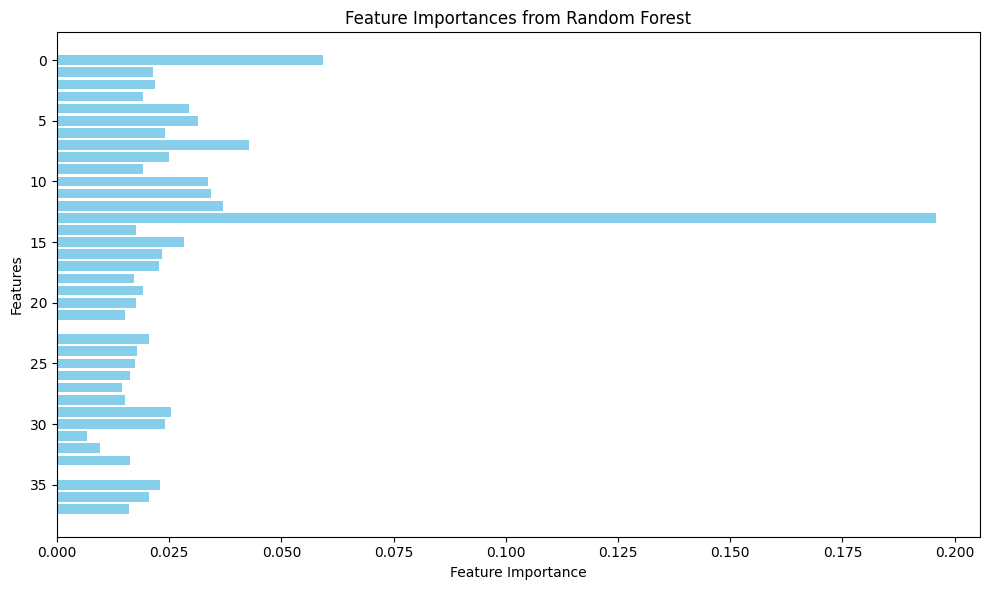

In [40]:
# Retrieve feature importance
feature_importances = model.feature_importances_

# Assuming 'X_train_scaled' is a DataFrame
if isinstance(X_train_scaled, pd.DataFrame):
    feature_names = X_train_scaled.columns
else:
    feature_names = [f"Feature {i}" for i in range(len(feature_importances))]

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print top features
print("\nTop Features by Importance:")
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.tight_layout()
plt.show()

In [30]:
# Initialize the XGBoost model
model = xgb.XGBClassifier(random_state=42)

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled.values)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Optional: Print the classification report for detailed metrics
print(classification_report(y_test, y_pred))


Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1586
           1       0.55      0.29      0.38       184

    accuracy                           0.90      1770
   macro avg       0.74      0.63      0.66      1770
weighted avg       0.88      0.90      0.89      1770



In [ ]:
# Understanding the feature Importance

# **1.5) Working with "Loan Purpose" an unstructured column using NLP**

In [41]:
# Step 2: Initialize the SBERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')  # You can choose other models from SentenceTransformers

In [42]:
# Step 3: Generate embeddings for the loan_purpose column
embeddings = sbert_model.encode(final_df['LoanPurpose'].tolist())


In [43]:
final_df_unstructured_embeddings=pd.DataFrame(embeddings)

In [44]:
final_df_unstructured_embeddings.shape

(8847, 384)

In [45]:
# Combine structured and unstructured features
final_df_combined=pd.concat([final_df_structured, final_df_unstructured_embeddings], axis=1)

In [46]:
final_df_combined.shape

(8847, 423)

In [47]:
final_df_combined.head()

,Amount,Term,Success,ALL_AgeOfOldestAccount,ALL_AgeOfYoungestAccount,ALL_Count,ALL_CountActive,ALL_CountClosedLast12Months,ALL_CountDefaultAccounts,ALL_CountOpenedLast12Months,...,374,375,376,377,378,379,380,381,382,383
0,2000,60,0,162,17,18,12,0,0,0,...,0.110894,-0.034285,0.009526,0.003064,-0.035418,0.042965,0.123704,-0.024491,0.001052,-0.011538
1,3000,60,0,266,30,14,10,0,4,0,...,0.030551,0.020010,-0.031726,0.055254,-0.013953,0.042591,-0.098610,0.071047,0.022440,-0.021748
2,20000,60,0,90,52,4,2,0,1,0,...,-0.012584,-0.042980,0.009985,0.008069,-0.089381,0.003925,-0.051086,-0.072753,0.089306,-0.014826
3,20000,60,0,163,19,14,6,1,1,0,...,0.060193,0.004075,0.014162,0.041807,0.004258,0.051532,-0.000232,-0.099092,0.024917,-0.005376
4,5000,36,0,129,2,38,19,4,9,8,...,0.012950,-0.008048,-0.014695,0.015265,-0.070287,0.002505,0.045130,0.052855,0.029912,0.086061


In [48]:
# Getting Input and target variables seperately
X = final_df_combined.drop('Success', axis=1)
y = final_df_combined['Success']

In [49]:
X.shape

(8847, 422)

# **Step 2: Data Preperation**

# **2.1) Train - Test Split**

In [50]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# **2.2) Normalize Structured Columns**

In [51]:
X_train.shape

(7077, 422)

In [52]:
X_test.shape

(1770, 422)

In [53]:
y_train.shape

(7077,)

In [54]:
X_train.head()

,Amount,Term,ALL_AgeOfOldestAccount,ALL_AgeOfYoungestAccount,ALL_Count,ALL_CountActive,ALL_CountClosedLast12Months,ALL_CountDefaultAccounts,ALL_CountOpenedLast12Months,ALL_CountSettled,...,374,375,376,377,378,379,380,381,382,383
6428,6000,30,197,3,11,5,2,0,2,6,...,-0.046160,0.069090,0.007698,-0.002931,-0.096941,0.036739,0.070315,-0.072219,0.021423,0.007676
3817,20000,60,158,16,15,7,0,0,0,8,...,-0.020489,-0.115387,0.040005,0.026529,-0.032797,0.000209,0.055940,-0.079266,0.033369,-0.102502
1458,9000,48,338,7,29,9,3,0,1,20,...,0.012950,-0.008048,-0.014695,0.015265,-0.070287,0.002505,0.045130,0.052855,0.029912,0.086061
3784,20000,54,118,11,13,7,1,0,1,6,...,-0.002495,-0.082850,0.005844,0.036838,-0.097663,-0.018588,0.038694,-0.080600,-0.042757,-0.063308
1036,6500,48,316,6,19,8,2,0,1,11,...,0.012950,-0.008048,-0.014695,0.015265,-0.070287,0.002505,0.045130,0.052855,0.029912,0.086061


In [55]:
# Selecting the first 39 columns
X_train_structured = X_train.iloc[:, :38]
X_test_structured = X_test.iloc[:, :38]

In [56]:
X_train_embeddings=X_train.iloc[:,38:]
X_test_embeddings=X_test.iloc[:,38:]

In [57]:
X_train_structured.shape

(7077, 38)

In [58]:
X_train_embeddings.shape

(7077, 384)

In [59]:
X_train_structured.head()

,Amount,Term,ALL_AgeOfOldestAccount,ALL_AgeOfYoungestAccount,ALL_Count,ALL_CountActive,ALL_CountClosedLast12Months,ALL_CountDefaultAccounts,ALL_CountOpenedLast12Months,ALL_CountSettled,...,Month_6.0,Month_7.0,Month_8.0,Month_9.0,Month_10.0,Month_11.0,Month_12.0,Quarter_2.0,Quarter_3.0,Quarter_4.0
6428,6000,30,197,3,11,5,2,0,2,6,...,False,False,False,False,False,False,False,False,False,False
3817,20000,60,158,16,15,7,0,0,0,8,...,False,False,False,False,False,False,False,False,False,False
1458,9000,48,338,7,29,9,3,0,1,20,...,False,False,False,False,False,False,False,False,False,False
3784,20000,54,118,11,13,7,1,0,1,6,...,False,False,False,False,False,False,False,False,False,False
1036,6500,48,316,6,19,8,2,0,1,11,...,False,False,False,False,False,False,False,False,False,False


In [60]:
X_test_structured.head()

,Amount,Term,ALL_AgeOfOldestAccount,ALL_AgeOfYoungestAccount,ALL_Count,ALL_CountActive,ALL_CountClosedLast12Months,ALL_CountDefaultAccounts,ALL_CountOpenedLast12Months,ALL_CountSettled,...,Month_6.0,Month_7.0,Month_8.0,Month_9.0,Month_10.0,Month_11.0,Month_12.0,Quarter_2.0,Quarter_3.0,Quarter_4.0
626,5500,48,217,11,17,8,2,0,1,9,...,False,False,False,False,False,False,True,False,False,True
8657,1000,12,177,2,62,8,11,2,5,54,...,False,False,True,False,False,False,False,False,True,False
7558,18000,60,317,2,23,9,1,0,2,14,...,False,False,False,False,False,False,False,False,False,False
5745,6000,24,300,2,22,12,0,0,3,10,...,False,False,False,False,False,False,False,False,False,False
6231,15000,60,97,1,17,5,4,2,5,12,...,False,False,False,False,False,False,False,False,False,False


In [61]:
# Apply normalization to structured columns
scaler = StandardScaler()
X_train_structured_scaled = scaler.fit_transform(X_train_structured)
X_test_structured_scaled = scaler.transform(X_test_structured)

# Convert back to DataFrame
X_train_structured_scaled = pd.DataFrame(X_train_structured_scaled)
X_test_structured_scaled = pd.DataFrame(X_test_structured_scaled)

In [62]:
X_train_structured_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,-0.300990,-0.748585,0.360073,-0.422553,-0.462644,-0.875012,0.153367,-0.500129,-0.148886,-0.189351,...,-0.204844,-0.177856,-0.192549,-0.18121,-0.194513,-0.185736,-0.178278,-0.349918,-0.33,-0.334457
1,2.330458,1.111966,-0.051861,0.536053,-0.177825,-0.465268,-0.598020,-0.500129,-0.810531,-0.017408,...,-0.204844,-0.177856,-0.192549,-0.18121,-0.194513,-0.185736,-0.178278,-0.349918,-0.33,-0.334457
2,0.262892,0.367746,1.849374,-0.127597,0.819039,-0.055524,0.529061,-0.500129,-0.479709,1.014247,...,-0.204844,-0.177856,-0.192549,-0.18121,-0.194513,-0.185736,-0.178278,-0.349918,-0.33,-0.334457
3,2.330458,0.739856,-0.474358,0.167358,-0.320234,-0.465268,-0.222327,-0.500129,-0.479709,-0.189351,...,-0.204844,-0.177856,-0.192549,-0.18121,-0.194513,-0.185736,-0.178278,-0.349918,-0.33,-0.334457
4,-0.207010,0.367746,1.617001,-0.201336,0.106993,-0.260396,0.153367,-0.500129,-0.479709,0.240506,...,-0.204844,-0.177856,-0.192549,-0.18121,-0.194513,-0.185736,-0.178278,-0.349918,-0.33,-0.334457


In [63]:
X_train_structured_scaled.shape

(7077, 38)

In [64]:
X_train_embeddings.shape

(7077, 384)

# **2.3) Combine Normalized Structured Columns with Word Embeddings**

In [65]:
X_train_structured_scaled = X_train_structured_scaled.reset_index(drop=True)
X_train_embeddings = X_train_embeddings.reset_index(drop=True)

X_train_combined_scaled = pd.concat([X_train_structured_scaled, X_train_embeddings], axis=1)


X_test_structured_scaled = X_test_structured_scaled.reset_index(drop=True)
X_test_embeddings = X_test_embeddings.reset_index(drop=True)

X_test_combined_scaled = pd.concat([X_test_structured_scaled, X_test_embeddings], axis=1)


In [66]:
X_test_combined_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.394971,0.367746,0.571321,0.167358,-0.035416,-0.260396,0.153367,-0.500129,-0.479709,0.068563,...,0.012950,-0.008048,-0.014695,0.015265,-0.070287,0.002505,0.045130,0.052855,0.029912,0.086061
1,-1.240793,-1.864915,0.148825,-0.496292,3.168789,-0.260396,3.534611,0.231911,0.843580,3.937269,...,-0.044929,0.015215,0.005084,-0.080293,0.046073,-0.011725,0.095275,-0.025494,0.120828,0.005305
2,1.954537,1.111966,1.627563,-0.496292,0.391811,-0.055524,-0.222327,-0.500129,-0.148886,0.498419,...,0.071939,-0.016159,0.020189,-0.082775,-0.000209,0.010733,0.030705,-0.016253,0.008970,-0.024788
3,-0.300990,-1.120695,1.448002,-0.496292,0.320607,0.559092,-0.598020,-0.500129,0.181936,0.154534,...,0.044335,0.032408,0.037515,-0.011815,0.030435,0.056567,0.003301,-0.045071,0.036851,0.090253
4,1.390655,1.111966,-0.696169,-0.570031,-0.035416,-0.875012,0.904755,0.231911,0.843580,0.326477,...,0.008461,-0.025943,0.078431,-0.051152,0.061844,0.007488,0.069387,0.008310,-0.006515,0.052069


In [67]:
X_train_combined_scaled.shape

(7077, 422)

# **2.4) Apply SMOTE on the combined dataset to address class imbalance**

In [68]:
y_train.value_counts(normalize=True)

,proportion
Success,
0,0.895719
1,0.104281


In [69]:

# Apply SMOTE on training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_combined_scaled, y_train)


In [70]:
X_train_balanced.shape

(12678, 422)

In [71]:
# Convert all column names to strings
X_train_combined_scaled.columns = X_train_combined_scaled.columns.astype(str)
X_test_combined_scaled.columns = X_test_combined_scaled.columns.astype(str)



# **Step 3: Model Building**

# **3.1) Model without SMOTE**

In [72]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)  # Increase max_iter if needed

# Train the model
model.fit(X_train_combined_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_combined_scaled)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Optional: Print the classification report for detailed metrics
print(classification_report(y_test, y_pred))


Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.90      0.99      0.95      1586
           1       0.52      0.07      0.12       184

    accuracy                           0.90      1770
   macro avg       0.71      0.53      0.53      1770
weighted avg       0.86      0.90      0.86      1770



In [73]:
# Initialize the Random Forest model

# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_combined_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_combined_scaled)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Optional: Print the classification report for detailed metrics
print(classification_report(y_test, y_pred))

Accuracy: 0.89
              precision    recall  f1-score   support

           0       0.90      1.00      0.94      1586
           1       0.38      0.02      0.03       184

    accuracy                           0.89      1770
   macro avg       0.64      0.51      0.49      1770
weighted avg       0.84      0.89      0.85      1770



In [74]:
# Initialize the XGBoost model
model = xgb.XGBClassifier(random_state=42)

# Train the model
model.fit(X_train_combined_scaled.values, y_train)

# Make predictions
y_pred = model.predict(X_test_combined_scaled.values)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Optional: Print the classification report for detailed metrics
print(classification_report(y_test, y_pred))


Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1586
           1       0.53      0.28      0.37       184

    accuracy                           0.90      1770
   macro avg       0.73      0.63      0.66      1770
weighted avg       0.88      0.90      0.89      1770



# **3.2) Model with SMOTE**

In [75]:

# Initialize the Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)  # Increase max_iter if needed

# Train the model
model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred = model.predict(X_test_combined_scaled)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Optional: Print the classification report for detailed metrics
print(classification_report(y_test, y_pred))


Accuracy: 0.73
              precision    recall  f1-score   support

           0       0.96      0.73      0.83      1586
           1       0.24      0.75      0.37       184

    accuracy                           0.73      1770
   macro avg       0.60      0.74      0.60      1770
weighted avg       0.89      0.73      0.78      1770



In [76]:
# Initialize the Randon Forest model

# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred = model.predict(X_test_combined_scaled)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Optional: Print the classification report for detailed metrics
print(classification_report(y_test, y_pred))


Accuracy: 0.89
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1586
           1       0.42      0.11      0.18       184

    accuracy                           0.89      1770
   macro avg       0.66      0.55      0.56      1770
weighted avg       0.85      0.89      0.86      1770



In [77]:
# Initialize the XGBoost model
model = xgb.XGBClassifier(random_state=42)

# Train the model
model.fit(X_train_balanced.values, y_train_balanced)

# Make predictions
y_pred = model.predict(X_test_combined_scaled.values)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Optional: Print the classification report for detailed metrics
print(classification_report(y_test, y_pred))


Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1586
           1       0.51      0.34      0.41       184

    accuracy                           0.90      1770
   macro avg       0.72      0.65      0.68      1770
weighted avg       0.88      0.90      0.89      1770



In [78]:

# Initialize and train Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_balanced, y_train_balanced)

# Evaluate
y_pred_gb = gb_model.predict(X_test_combined_scaled)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting Accuracy: {accuracy_gb:.2f}")
# Optional: Print the classification report for detailed metrics
print(classification_report(y_test, y_pred))

Gradient Boosting Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1586
           1       0.51      0.34      0.41       184

    accuracy                           0.90      1770
   macro avg       0.72      0.65      0.68      1770
weighted avg       0.88      0.90      0.89      1770



In [79]:
# Saving XGBOOST model as Pickle  - Model Productionalisation

import pickle
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Train the XGBoost model
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train_balanced.values, y_train_balanced)

# Save the trained model to a pickle file
model_filename = 'xgboost_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)
print(f"Model saved as {model_filename}")

# ---- To Load and Use the Model for Predictions ----

# Load the model from the pickle file
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully")

# Use the loaded model to make predictions
y_pred = loaded_model.predict(X_test_combined_scaled.values)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using loaded model: {accuracy:.2f}")

# Print classification report
print(classification_report(y_test, y_pred))


Model saved as xgboost_model.pkl
Model loaded successfully
Accuracy using loaded model: 0.90
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1586
           1       0.51      0.34      0.41       184

    accuracy                           0.90      1770
   macro avg       0.72      0.65      0.68      1770
weighted avg       0.88      0.90      0.89      1770



# **Hyper parameter tuning**

In [ ]:

# Hyperparameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(xgb.XGBClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_balanced.values, y_train_balanced)

# Best model
best_xgb_model = grid_search.best_estimator_
y_pred_best_xgb = best_xgb_model.predict(X_test_combined_scaled)
accuracy_best_xgb = accuracy_score(y_test, y_pred_best_xgb)
print(f"Best XGBoost Accuracy: {accuracy_best_xgb:.2f}")

# Optional: Print the classification report for detailed metrics
print(classification_report(y_test, y_pred_best_xgb))

# **Neural Networks**

In [80]:

# Define the model
model_nn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_balanced.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # For binary classification
])

# Compile the model
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_nn.fit(X_train_balanced, y_train_balanced, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate
accuracy_nn = model_nn.evaluate(X_test_combined_scaled, y_test, verbose=0)[1]
print(f"Neural Network Accuracy: {accuracy_nn:.2f}")


Epoch 1/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6961 - loss: 0.5583 - val_accuracy: 0.7259 - val_loss: 0.6015
Epoch 2/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8108 - loss: 0.4019 - val_accuracy: 0.7614 - val_loss: 0.5591
Epoch 3/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8458 - loss: 0.3460 - val_accuracy: 0.8462 - val_loss: 0.4074
Epoch 4/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8641 - loss: 0.3159 - val_accuracy: 0.8537 - val_loss: 0.4007
Epoch 5/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8859 - loss: 0.2765 - val_accuracy: 0.9302 - val_loss: 0.2360
Epoch 6/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8944 - loss: 0.2464 - val_accuracy: 0.9444 - val_loss: 0.2052
Epoch 7/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9073 - loss: 0.2263 - val_accuracy: 0.9539 - val_loss: 0.1772
Epoch 8/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9153 - loss: 0.2111 - val_accuracy: 0.

In [81]:

# Precision, Recall, F1-score
precision = precision_score(y_test, y_pred, average='binary')  # Use 'macro' or 'weighted' for multi-class
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Or print a detailed classification report
print(classification_report(y_test, y_pred))


Precision: 0.51
Recall: 0.34
F1 Score: 0.41
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1586
           1       0.51      0.34      0.41       184

    accuracy                           0.90      1770
   macro avg       0.72      0.65      0.68      1770
weighted avg       0.88      0.90      0.89      1770

